# Introduction

This notebook demonstrates how to build and deploy an AutoML model using the Google's Vertex-AI Python Client.

# Setup

Installations:

In [1]:
! pip3 install --upgrade --quiet google-cloud-aiplatform

In [2]:
!pip install gdown

inputs:

In [3]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
REGION = 'us-central1'
print(f'project id: {PROJECT_ID}')

project id: auto-ml-433608


In [4]:
DATANAME = 'churn'

In [5]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = DATANAME
BQ_TABLE = 'churn_tbl'

In [6]:
SOURCE_FILE_NAME = 'churn_data.csv'

In [7]:
VAR_TARGET = 'Exited'

packages:

In [8]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import gdown
import os

clients:

In [9]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project = PROJECT_ID)

resources:

In [10]:
DEPLOY_COMPUTE = 'n1-standard-2'

# Download the data & load to BigQuery

Note: You can view the created dataset and tables through the BigQuery menu in the GCP Console UI.

Download the csv file:

In [11]:
gdown.download(f"https://drive.google.com/uc?export=download&id=1l6PZwNBIJ4urIRduH32gSa7fa_LO_KTp", SOURCE_FILE_NAME, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1l6PZwNBIJ4urIRduH32gSa7fa_LO_KTp
To: /home/jupyter/churn_data.csv
100%|██████████| 837k/837k [00:00<00:00, 87.4MB/s]


'churn_data.csv'

Create an empty BigQuery dataset (In BigQuery, tables must reside within a dataset, which is essentially a container for tables that provides organizational structure and access control to the tables):

In [12]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = REGION
ds = bq.create_dataset(dataset = ds, exists_ok = True)

Load the data from the csv file into the BigQuery dataset:

In [13]:
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,
    autodetect=True # Let BigQuery autodetect the schema
)

with open(SOURCE_FILE_NAME, "rb") as source_file:
    load_job = bq.load_table_from_file(
        source_file,
        ds.table(BQ_TABLE),
        job_config=job_config,
    )

load_job.result()

print(f"Loaded {load_job.output_rows} rows into {BQ_DATASET}.{BQ_TABLE}.")

Loaded 10000 rows into churn.churn_tbl.


Store the table name in the `table_ref` variable for future reuse:

In [14]:
table_ref = f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}"

Remove white spaces in column names by transforming them into underscores (AutoML prohibits column names with whitespace):

In [15]:
table = bq.get_table(table_ref)
columns = [schema.name for schema in table.schema]
cleaned_columns = [f"`{col}` AS `{col.replace(' ', '_')}`" for col in columns]

In [16]:
query = f"""
CREATE OR REPLACE TABLE {table_ref} AS
SELECT
  {', '.join(cleaned_columns)}
FROM
  {table_ref};
"""
job = bq.query(query=query)
job.result()

print(f"Columns cleaned in place and table `{BQ_TABLE}` updated in `{BQ_DATASET}` dataset.")

Columns cleaned in place and table `churn_tbl` updated in `churn` dataset.


Remove the csv file as it is no longer needed:

In [17]:
os.remove(SOURCE_FILE_NAME)

Display target class imbalance:

In [18]:
query = f"""
SELECT {VAR_TARGET}
FROM {table_ref}
"""
df = bq.query(query = query).to_dataframe()

In [19]:
df[VAR_TARGET].value_counts()

Exited
0    7962
1    2038
Name: count, dtype: Int64

Prepare data for analysis - split into train, validation, and test sets while maintaining the proportions of the target class in each set. Store the table name in the `table_ref_prepped` variable for future reuse:

In [20]:
table_ref_prepped = f'{table_ref}_prepped'

In [21]:
table = bq.get_table(table_ref)
columns = [field.name for field in table.schema]

query = f"""
CREATE OR REPLACE TABLE {table_ref_prepped} AS
WITH class_counts AS (
  /*
  This Common Table Expression (CTE) calculates the total number of records for each value of the target (Exited) column
  */
  SELECT 
    {VAR_TARGET},
    COUNT(*) as total_count
  FROM 
    {table_ref}
  GROUP BY 
    {VAR_TARGET}
),
stratified_data AS (
  /*
   This CTE assigns a row number (stratified_row_num) to each record within each target class (exited),
   ensuring that the row numbers are ordered within each class.
   It also joins the class_counts data to bring in the total count for each class.
  */
  SELECT 
    source_table.*,
    ROW_NUMBER() OVER (PARTITION BY source_table.{VAR_TARGET} ORDER BY source_table.RowNumber) as stratified_row_num,
    class_counts.total_count
  FROM 
    {table_ref} AS source_table
  JOIN 
    class_counts
  ON 
    source_table.{VAR_TARGET} = class_counts.{VAR_TARGET}
),
split_data AS (
  /*
  CTE determines the data split (train, validation, or test) for each record based on the stratified_row_num and the total_count for the class.
  Please note that the splits groups must be written with capital letters, i.e. TRAIN, TEST and VALIDATE
  */
  SELECT *,
         CASE 
           WHEN stratified_row_num <= 0.7 * total_count THEN 'TRAIN'
           WHEN stratified_row_num > 0.7 * total_count AND stratified_row_num <= 0.9 * total_count THEN 'VALIDATE'
           ELSE 'TEST'
         END as split
  FROM stratified_data
)
/*
List all columns from the original table explicitly.
This is required as we used columns such as stratified_row_num and total_count for the splitting operation.
*/
SELECT {", ".join(columns)}, split FROM split_data;
"""
job = bq.query(query=query)
job.result();

In [22]:
query = f"""
SELECT *
FROM {table_ref_prepped} LIMIT 5
"""
bq.query(query = query).to_dataframe()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction_Score,Card_Type,Point_Earned,split
0,2648,15687162,Clayton,461,France,Male,51,9,119889.84,1,0,0,56767.67,1,1,1,GOLD,933,TRAIN
1,6105,15750731,Trevisani,736,Germany,Male,50,9,116309.01,1,1,0,185360.40,1,1,1,GOLD,760,TRAIN
2,6628,15746199,Eluemuno,558,France,Female,41,6,0.00,1,1,1,143585.29,1,1,1,GOLD,331,TRAIN
3,7689,15592412,Sun,713,Germany,Male,45,4,131038.14,1,1,0,74005.04,1,1,2,GOLD,495,VALIDATE
4,376,15758449,Angelo,769,France,Female,39,8,0.00,1,0,1,21016.00,0,0,3,GOLD,828,TRAIN


Verifying Proper Stratified Ratios Across Training, Validation, and Test Splits:

In [23]:
query = f"""
SELECT 
    split,
    COUNTIF({VAR_TARGET} = 1) AS exited_count,
    COUNTIF({VAR_TARGET} = 0) AS not_exited_count
FROM 
    {table_ref_prepped}
GROUP BY 
    split
ORDER BY 
    split;
"""

df = bq.query(query).to_dataframe()

In [24]:
df['total_count'] = df['exited_count'] + df['not_exited_count']
df['exited_%'] = df['exited_count'] / df['total_count'] * 100
df['not_exited_%'] = df['not_exited_count'] / df['total_count'] * 100
df

,split,exited_count,not_exited_count,total_count,exited_%,not_exited_%
0,TEST,204,797,1001,20.37962,79.62038
1,TRAIN,1426,5573,6999,20.374339,79.625661
2,VALIDATE,408,1592,2000,20.4,79.6


# Create the Vertex AI dataset

A Vertex AI dataset is a structured collection of data stored in Google Cloud

In [25]:
dataset = aiplatform.TabularDataset.create(
    display_name=DATANAME,
    bq_source=f'bq://{table_ref_prepped}'
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/852126792524/locations/us-central1/datasets/1118897117285318656/operations/3600265235044237312
TabularDataset created. Resource name: projects/852126792524/locations/us-central1/datasets/1118897117285318656
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/852126792524/locations/us-central1/datasets/1118897117285318656')


# Train a model

The model can be viewed in the UI under Vertex AI's `Model Registry` menu.

Omit the `RowNumber`, `CustomerId`, and `Surname` columns, as they don't contribute relevant information for prediction. Additionally, remove the `Complain` column due to its high correlation with the class label, which could introduce bias into the prediction. Finally, exclude the target column.

In [26]:
TO_OMIT = ['RowNumber', 'CustomerId', 'Surname', 'Complain', VAR_TARGET]

In [27]:
column_specs = list(set(dataset.column_names) - set(TO_OMIT))

In [28]:
column_specs = dict.fromkeys(column_specs, 'auto')
column_specs

{'Age': 'auto',
 'Card_Type': 'auto',
 'Point_Earned': 'auto',
 'IsActiveMember': 'auto',
 'Tenure': 'auto',
 'Geography': 'auto',
 'HasCrCard': 'auto',
 'NumOfProducts': 'auto',
 'Gender': 'auto',
 'Satisfaction_Score': 'auto',
 'Balance': 'auto',
 'EstimatedSalary': 'auto',
 'CreditScore': 'auto',
 'split': 'auto'}

Define a job:

In [29]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = DATANAME,
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs
)

Train the model:

In [30]:
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'split',
    #    training_fraction_split = 0.7,
    #    validation_fraction_split = 0.2,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = DATANAME,
    disable_early_stopping = False
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/6606906994110496768?project=852126792524
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/6606906994110496768 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/6606906994110496768 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/6606906994110496768 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/6606906994110496768 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trainingPipelines/6606906994110496768 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/852126792524/locations/us-central1/trai

# Model Evaluation

Evaluating the model can also be done through the UI.
This section demonstrates how to do it using the Python client:

In [31]:
# If the model already exists and you're re-running this notebook, load the model by running this cell:
# model_resource_name = 'projects/852126792524/locations/us-central1/models/7198257435956477952' # fill up the model's resource id
# model = aiplatform.Model(model_resource_name)

In [32]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [33]:
evaluation = model.get_model_evaluation().to_dict()

In [34]:
metrics = evaluation['metrics']
metrics.keys()

dict_keys(['auPrc', 'auRoc', 'logLoss', 'confusionMatrix', 'confidenceMetrics'])

In [35]:
print("PR AUC:", metrics.get('auPrc'))
print("ROC AUC:", metrics.get('auRoc'))
print("logLoss:", metrics.get('logLoss'))

PR AUC: 0.922778
ROC AUC: 0.92536384
logLoss: 0.34701425


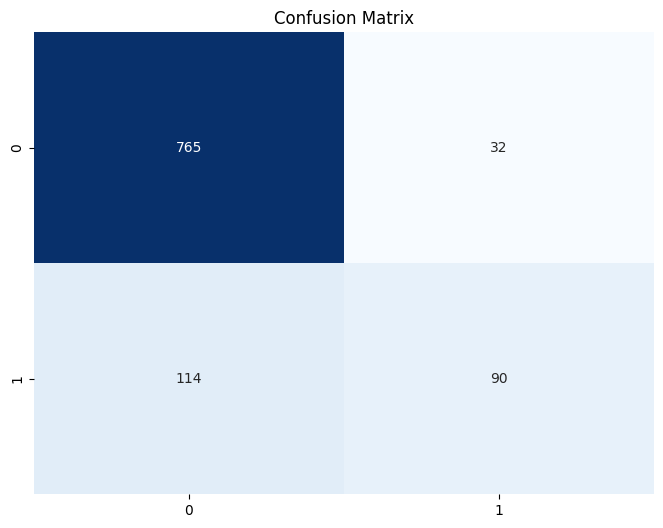

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_matrix = metrics.get('confusionMatrix')
   
cm = np.array(confusion_matrix['rows'])
cm = cm[:-1,:-1] # remove dropped

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()

While it's evident that the model has a significant number of false negatives, the focus of this notebook is not on optimizing model performance but rather on exploring and understanding Vertex AI's AutoML tools. Therefore, I will not be delving into the quality of the model in this notebook.

# Create an Endpoint and Deployment

The endpoint can be viewed in the UI under Vertex AI's `Online Prediction` menu.

In [37]:
# If the model already exists and you're re-running this notebook, load the model by running this cell:
# model_resource_name = 'projects/852126792524/locations/us-central1/models/7198257435956477952' # fill up the model's resource id
# model = aiplatform.Model(model_resource_name)

In [38]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{DATANAME}_endpoint'
)

Creating Endpoint
Create Endpoint backing LRO: projects/852126792524/locations/us-central1/endpoints/3705615869372530688/operations/2365645618447122432
Endpoint created. Resource name: projects/852126792524/locations/us-central1/endpoints/3705615869372530688
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/852126792524/locations/us-central1/endpoints/3705615869372530688')


Deploy the model to the endpoint (this process may take some time, so please be patient):

In [39]:
deployed_model = endpoint.deploy(
    model=model,
    deployed_model_display_name=f'{DATANAME}_model',
    traffic_percentage=100,
    machine_type=DEPLOY_COMPUTE,
    min_replica_count=1,
    max_replica_count=1
)

Deploying Model projects/852126792524/locations/us-central1/models/9209677619530825728 to Endpoint : projects/852126792524/locations/us-central1/endpoints/3705615869372530688
Deploy Endpoint model backing LRO: projects/852126792524/locations/us-central1/endpoints/3705615869372530688/operations/2311602422918676480
Endpoint model deployed. Resource name: projects/852126792524/locations/us-central1/endpoints/3705615869372530688


# Prediction

Retrieve some test data from the BigQuery table:

In [40]:
query = f"""
(
  SELECT * FROM {table_ref_prepped}
  WHERE split='TEST' AND Exited=1 
  LIMIT 3
)
UNION ALL
(
  SELECT * FROM {table_ref_prepped}
  WHERE split='TEST' AND Exited=0 
  LIMIT 3
)
"""

pred = bq.query(query=query).to_dataframe()
pred

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction_Score,Card_Type,Point_Earned,split
0,9372,15781987,Akhtar,641,France,Male,31,9,112494.99,1,1,1,32231.60,0,0,4,GOLD,565,TEST
1,9581,15778838,Warren,783,France,Male,38,9,114135.17,1,1,0,153269.98,0,0,2,GOLD,343,TEST
2,9844,15778304,Fan,646,Germany,Male,24,0,92398.08,1,1,1,18897.29,0,0,5,GOLD,887,TEST
3,9211,15792650,Watts,382,Spain,Male,36,0,0.00,1,1,1,179540.73,1,1,4,GOLD,659,TEST
4,9009,15776936,Whitworth,475,France,Male,40,7,160818.08,1,0,1,169642.13,1,1,5,GOLD,219,TEST
5,9357,15734711,Loggia,373,France,Male,42,7,0.00,1,1,0,77786.37,1,1,3,GOLD,986,TEST


Predict a single entry. First, remove unnecessary columns and convert all fields to strings:

In [41]:
newob = pred[pred.columns[~pred.columns.isin(TO_OMIT + [VAR_TARGET, 'split'])]].to_dict(orient='records')[0]
newob

{'CreditScore': 641,
 'Geography': 'France',
 'Gender': 'Male',
 'Age': 31,
 'Tenure': 9,
 'Balance': 112494.99,
 'NumOfProducts': 1,
 'HasCrCard': 1,
 'IsActiveMember': 1,
 'EstimatedSalary': 32231.6,
 'Satisfaction_Score': 4,
 'Card_Type': 'GOLD',
 'Point_Earned': 565}

First, we need to convert the categorical fields into strings as AutoML preprocessing did:

In [42]:
def convert_for_prediction(entry):
    fields_to_convert = [
        'CreditScore', 'Age', 'Tenure', 'NumOfProducts',
        'HasCrCard', 'IsActiveMember', 'Satisfaction_Score', 'Point_Earned'
    ]
    
    for field in fields_to_convert:
        entry[field] = str(entry[field])
    
    return entry

In [43]:
newob = convert_for_prediction(newob)

Then, use the endpoint for prediction:

In [44]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())
prediction = endpoint.predict(instances=instances, parameters=parameters)
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.9488348960876465, 0.05116508901119232]}], deployed_model_id='3675861985213284352', metadata=None, model_version_id='1', model_resource_name='projects/852126792524/locations/us-central1/models/9209677619530825728', explanations=None)

In [45]:
pred_class = prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]
print(f'predicted class: {pred_class}')

predicted class: 0


# Explainability

In [48]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [49]:
explanation.predictions

[{'classes': ['0', '1'], 'scores': [0.9488348960876465, 0.05116508901119232]}]

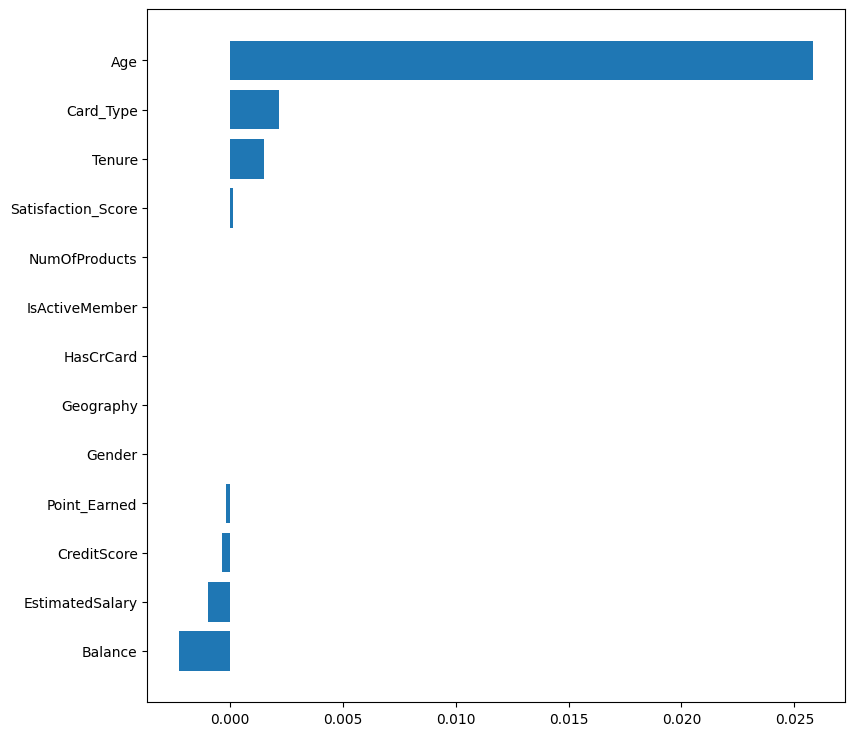

In [50]:
import matplotlib.pyplot as plt
features = []
scores = []

# Extract features and scores from the explanation object
attributions = explanation.explanations[0].attributions[0].feature_attributions

features = list(attributions.keys())
scores = list(attributions.values())
sorted_pairs = sorted(zip(scores, features))
scores, features = zip(*sorted_pairs)

fig, ax = plt.subplots(figsize=(9, 9))
ax.barh(features, scores)
fig.show()

Note: In his tutorial, Mike also demonstrated batch prediction where the samples are taken from BigQuery, and the predictions are also stored there. I skipped this part.

# Deletion

Mike provided a [deletion process via Python code](https://github.com/statmike/vertex-ai-mlops/blob/main/99%20-%20Cleanup/99%20-%20Cleanup.ipynb)

I decided to ensure I also knew how to delete the resources manually fron the UI and found it to be very straightforward. 

The only point worth mentioning is that to delete the deployment endpoint and the model, you must first undeploy the model from the endpoint — only then can you delete both the model and the endpoint itself.